In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Deep_learning_final

/content/drive/MyDrive/Colab Notebooks/Deep_learning_final


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

class MultiSizeAdversarialPatchGenerator:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def create_patches(self, sizes=[(3,3), (5,5), (7,7), (16,16)]):
        """
        Create multiple patch sizes

        Args:
            sizes (list): List of patch sizes to generate

        Returns:
            dict: Dictionary of patches with their respective sizes
        """
        patches = {}
        for size in sizes:
            # Random initialization with scaled values
            patch = torch.randn(3, *size, device=self.device) * 0.1
            patch.requires_grad = True
            patches[size] = patch
        return patches

    def place_patch(self, img, patch, placement_strategy='random'):
        """
        Place patch on images with different placement strategies

        Args:
            img (torch.Tensor): Original images
            patch (torch.Tensor): Adversarial patch
            placement_strategy (str): Patch placement method

        Returns:
            torch.Tensor: Images with applied patch
        """
        batch_size, _, h, w = img.size()
        ph, pw = patch.size(1), patch.size(2)

        if placement_strategy == 'random':
            # Random placement
            top = torch.randint(0, h - ph, (batch_size,)).to(self.device)
            left = torch.randint(0, w - pw, (batch_size,)).to(self.device)

            for i in range(batch_size):
                img[i, :, top[i]:top[i]+ph, left[i]:left[i]+pw] = patch
        elif placement_strategy == 'center':
            # Center placement
            top = (h - ph) // 2
            left = (w - pw) // 2
            img[:, :, top:top+ph, left:left+pw] = patch

        return img

    def train_patches(self, patches, target_class, dataloader, num_epochs=10):
        """
        Train multiple adversarial patches

        Args:
            patches (dict): Dictionary of patches to train
            target_class (int): Target class for attack
            dataloader (torch.utils.data.DataLoader): Training data loader
            num_epochs (int): Number of training epochs

        Returns:
            dict: Trained adversarial patches
        """
        trained_patches = {}

        for size, patch in patches.items():
            print(f"\nTraining patch for size {size}")

            # Optimizer with adaptive learning rate
            patch_optimizer = optim.Adam([patch], lr=0.01, weight_decay=1e-4)
            lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                patch_optimizer, mode='min', factor=0.5, patience=5, verbose=True
            )
            criterion = nn.CrossEntropyLoss()

            best_loss = float('inf')
            best_patch = None

            for epoch in range(num_epochs):
                self.model.train()
                total_loss = 0

                for images, labels in dataloader:
                    images = images.to(self.device)
                    patch_optimizer.zero_grad()

                    # Apply patch with different strategies
                    strategies = ['random', 'center']
                    batch_losses = []

                    for strategy in strategies:
                        patched_images = self.place_patch(images.clone(), patch, strategy)

                        # Create target labels for the targeted attack
                        target_labels = torch.full((images.size(0),), target_class,
                                                   dtype=torch.long, device=self.device)

                        # Forward pass through the model
                        outputs = self.model(patched_images)

                        # Compute the loss for targeted attack
                        loss = criterion(outputs, target_labels)
                        batch_losses.append(loss)

                    # Average loss across strategies
                    avg_loss = torch.mean(torch.stack(batch_losses))
                    avg_loss.backward()
                    patch_optimizer.step()

                    # Clip patch values
                    with torch.no_grad():
                        patch.data = torch.clamp(patch.data, -0.5, 0.5)

                    total_loss += avg_loss.item()

                # Learning rate scheduling
                lr_scheduler.step(total_loss)

                # Track best patch
                if total_loss < best_loss:
                    best_loss = total_loss
                    best_patch = patch.clone()

                if epoch % 5 == 0:
                    print(f"Size {size}, Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

            trained_patches[size] = best_patch

        return trained_patches

    def evaluate_patches(self, patches, dataloader, target_class):
        """
        Evaluate multiple adversarial patches

        Args:
            patches (dict): Dictionary of patches to evaluate
            dataloader (torch.utils.data.DataLoader): Test data loader
            target_class (int): Target class for attack

        Returns:
            dict: Attack success rates for each patch size
        """
        success_rates = {}

        for size, patch in patches.items():
            print(f"\nEvaluating patch for size {size}")

            self.model.eval()
            correct = 0
            total = 0

            # Evaluate with different placement strategies
            placement_strategies = ['random', 'center']
            strategy_success_rates = []

            for strategy in placement_strategies:
                temp_correct = 0
                temp_total = 0

                with torch.no_grad():
                    for images, labels in dataloader:
                        images, labels = images.to(self.device), labels.to(self.device)
                        patched_images = self.place_patch(images.clone(), patch, strategy)

                        outputs = self.model(patched_images)
                        _, predicted = outputs.max(1)

                        # Calculate success for targeted attack
                        temp_correct += (predicted == target_class).sum().item()
                        temp_total += labels.size(0)

                strategy_success_rate = 100 * temp_correct / temp_total
                strategy_success_rates.append(strategy_success_rate)
                print(f"Attack Success Rate ({strategy} placement): {strategy_success_rate:.2f}%")

            # Average success rate across strategies
            success_rates[size] = np.mean(strategy_success_rates)

        return success_rates

    def visualize_patches(self, patches):
        """
        Visualize generated patches

        Args:
            patches (dict): Dictionary of patches to visualize
        """
        plt.figure(figsize=(12, 3))

        for i, (size, patch) in enumerate(patches.items(), 1):
            patch_np = patch.detach().cpu().numpy()
            patch_np = np.clip((patch_np - patch_np.min()) / (patch_np.max() - patch_np.min()), 0, 1)

            plt.subplot(1, len(patches), i)
            plt.imshow(np.transpose(patch_np, (1, 2, 0)))
            plt.title(f"Patch Size {size}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [18]:
class EnhancedAdversarialPatchGenerator:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def create_patches(self, sizes=[(3,3), (5,5), (7,7), (16,16)]):
        """
        Create multiple patch sizes with improved initialization
        """
        patches = {}
        for size in sizes:
            # Improved initialization strategy
            patch = torch.zeros(3, *size, device=self.device)
            patch.requires_grad = True
            patches[size] = patch
        return patches

    def place_patch(self, img, patch, placement_strategy='random'):
        """
        Enhanced patch placement with more strategic positioning
        """
        batch_size, _, h, w = img.size()
        ph, pw = patch.size(1), patch.size(2)

        if placement_strategy == 'random':
            # More strategic random placement
            top = torch.randint(0, max(1, h - ph), (batch_size,)).to(self.device)
            left = torch.randint(0, max(1, w - pw), (batch_size,)).to(self.device)

            for i in range(batch_size):
                img[i, :, top[i]:top[i]+ph, left[i]:left[i]+pw] = patch
        elif placement_strategy == 'center':
            # Center placement
            top = (h - ph) // 2
            left = (w - pw) // 2
            img[:, :, top:top+ph, left:left+pw] = patch
        elif placement_strategy == 'multiple':
            # Multiple smaller patch placements
            num_patches = min(3, (h // ph) * (w // pw))
            for _ in range(num_patches):
                top = torch.randint(0, max(1, h - ph), (batch_size,)).to(self.device)
                left = torch.randint(0, max(1, w - pw), (batch_size,)).to(self.device)

                for i in range(batch_size):
                    img[i, :, top[i]:top[i]+ph, left[i]:left[i]+pw] = patch * 0.5

        return img

    def train_patches(self, patches, target_class, dataloader, num_epochs=50):
        """
        Advanced patch training with multiple loss components
        """
        trained_patches = {}

        for size, patch in patches.items():
            print(f"\nTraining patch for size {size}")

            # More advanced optimizer
            patch_optimizer = optim.Adam([patch], lr=0.1, weight_decay=1e-3)
            criterion = nn.CrossEntropyLoss()

            best_loss = float('inf')
            best_patch = None

            for epoch in range(num_epochs):
                self.model.train()
                epoch_losses = []

                for images, labels in dataloader:
                    images = images.to(self.device)
                    patch_optimizer.zero_grad()

                    # Multiple placement strategies
                    strategies = ['random', 'center', 'multiple']
                    batch_losses = []

                    for strategy in strategies:
                        # Clone images to avoid in-place modification
                        patched_images = self.place_patch(images.clone(), patch, strategy)

                        # Target labels for attack
                        target_labels = torch.full((images.size(0),), target_class,
                                                   dtype=torch.long, device=self.device)

                        # Forward pass
                        outputs = self.model(patched_images)

                        # Targeted attack loss
                        main_loss = criterion(outputs, target_labels)

                        # Regularization terms
                        patch_variation_loss = torch.std(patch)  # Encourage patch complexity
                        patch_magnitude_loss = torch.norm(patch)  # Prevent extreme values

                        # Combined loss
                        combined_loss = (
                            main_loss +
                            0.01 * patch_variation_loss +
                            0.001 * patch_magnitude_loss
                        )

                        batch_losses.append(combined_loss)

                    # Average loss across strategies
                    avg_loss = torch.mean(torch.stack(batch_losses))
                    avg_loss.backward()
                    patch_optimizer.step()

                    # Clip patch values
                    with torch.no_grad():
                        patch.data = torch.clamp(patch.data, -1, 1)

                    epoch_losses.append(avg_loss.item())

                # Average epoch loss
                mean_loss = np.mean(epoch_losses)

                # Track best patch
                if mean_loss < best_loss:
                    best_loss = mean_loss
                    best_patch = patch.clone()

                # Periodic logging
                if epoch % 5 == 0:
                    print(f"Size {size}, Epoch {epoch+1}/{num_epochs}, Loss: {mean_loss:.4f}")

            trained_patches[size] = best_patch

        return trained_patches

    def evaluate_patches(self, patches, dataloader, target_class):
        """
        Comprehensive patch evaluation
        """
        success_rates = {}

        for size, patch in patches.items():
            print(f"\nEvaluating patch for size {size}")

            self.model.eval()
            placement_strategies = ['random', 'center', 'multiple']
            strategy_success_rates = []

            for strategy in placement_strategies:
                correct = 0
                total = 0

                with torch.no_grad():
                    for images, labels in dataloader:
                        images, labels = images.to(self.device), labels.to(self.device)
                        patched_images = self.place_patch(images.clone(), patch, strategy)

                        outputs = self.model(patched_images)
                        _, predicted = outputs.max(1)

                        # Targeted attack success
                        correct += (predicted == target_class).sum().item()
                        total += labels.size(0)

                strategy_success_rate = 100 * correct / total
                strategy_success_rates.append(strategy_success_rate)
                print(f"Attack Success Rate ({strategy} placement): {strategy_success_rate:.2f}%")

            # Average success rate
            success_rates[size] = np.mean(strategy_success_rates)

        return success_rates

    def visualize_patches(self, patches):
        """
        Improved patch visualization
        """
        plt.figure(figsize=(16, 4))

        for i, (size, patch) in enumerate(patches.items(), 1):
            patch_np = patch.detach().cpu().numpy()

            # Normalize to [0, 1] range
            patch_np = (patch_np - patch_np.min()) / (patch_np.max() - patch_np.min())

            plt.subplot(1, len(patches), i)
            plt.imshow(np.transpose(patch_np, (1, 2, 0)))
            plt.title(f"Patch Size {size}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torchvision.models as models

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def train(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

# Train the model
train(model, trainloader, criterion, optimizer, num_epochs=20)

# Evaluate the model
evaluate(model, testloader)

# Save the model"cifar_resnet18_pretrained.pth"
torch.save(model.state_dict(), "cifar_resnet18_pretrained.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


Epoch [1/20], Loss: 1.0491
Epoch [2/20], Loss: 0.7044
Epoch [3/20], Loss: 0.6249
Epoch [4/20], Loss: 0.5670
Epoch [5/20], Loss: 0.5257
Epoch [6/20], Loss: 0.4940
Epoch [7/20], Loss: 0.4706
Epoch [8/20], Loss: 0.4484
Epoch [9/20], Loss: 0.4289
Epoch [10/20], Loss: 0.4134
Epoch [11/20], Loss: 0.4001
Epoch [12/20], Loss: 0.3927
Epoch [13/20], Loss: 0.3717
Epoch [14/20], Loss: 0.3669
Epoch [15/20], Loss: 0.3612
Epoch [16/20], Loss: 0.3502
Epoch [17/20], Loss: 0.3418
Epoch [18/20], Loss: 0.3391
Epoch [19/20], Loss: 0.3308
Epoch [20/20], Loss: 0.3228
Accuracy: 82.43%


In [14]:
# Create patch generator
patch_generator = MultiSizeAdversarialPatchGenerator(model, device)

# Target cat class
target_class = 3  # 'cat' in CIFAR-10

# Create patches for multiple sizes
#patches = patch_generator.create_patches(sizes=[(3,3), (5,5), (7,7), (16,16)])
patches = patch_generator.create_patches(sizes=[(3,3),(16,16)])

# Train patches
trained_patches = patch_generator.train_patches(patches, target_class, trainloader, num_epochs=50)

# Save trained patches
for size, patch in trained_patches.items():
    torch.save(patch, f'adversarial_patch_cat_{size[0]}x{size[1]}.pth')


Training patch for size (3, 3)
Size (3, 3), Epoch 1/50, Loss: 2821.5187
Size (3, 3), Epoch 6/50, Loss: 2807.4853
Size (3, 3), Epoch 11/50, Loss: 2808.5186
Size (3, 3), Epoch 16/50, Loss: 2801.8821
Size (3, 3), Epoch 21/50, Loss: 2807.7475
Size (3, 3), Epoch 26/50, Loss: 2806.5521
Size (3, 3), Epoch 31/50, Loss: 2803.5115
Size (3, 3), Epoch 36/50, Loss: 2804.5766
Size (3, 3), Epoch 41/50, Loss: 2803.6186
Size (3, 3), Epoch 46/50, Loss: 2807.6044

Training patch for size (16, 16)
Size (16, 16), Epoch 1/50, Loss: 2428.7657
Size (16, 16), Epoch 6/50, Loss: 2319.5484
Size (16, 16), Epoch 11/50, Loss: 2299.9993
Size (16, 16), Epoch 16/50, Loss: 2298.8923
Size (16, 16), Epoch 21/50, Loss: 2287.0233
Size (16, 16), Epoch 26/50, Loss: 2284.0930
Size (16, 16), Epoch 31/50, Loss: 2279.4178
Size (16, 16), Epoch 36/50, Loss: 2274.8257
Size (16, 16), Epoch 41/50, Loss: 2283.0898
Size (16, 16), Epoch 46/50, Loss: 2276.6091


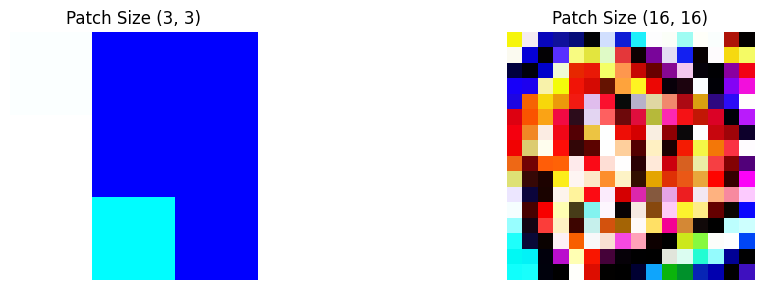

In [15]:
# Visualize patches
patch_generator.visualize_patches(trained_patches)

In [16]:
# Evaluate patches
success_rates = patch_generator.evaluate_patches(trained_patches, testloader, target_class)


Evaluating patch for size (3, 3)
Attack Success Rate (random placement): 12.51%
Attack Success Rate (center placement): 10.64%

Evaluating patch for size (16, 16)
Attack Success Rate (random placement): 10.73%
Attack Success Rate (center placement): 7.65%


In [17]:
# Print overall results
print("\nOverall Attack Success Rates:")
for size, rate in success_rates.items():
    print(f"Patch Size {size}: {rate:.2f}%")


Overall Attack Success Rates:
Patch Size (3, 3): 11.57%
Patch Size (16, 16): 9.19%


In [20]:
patch_generator = EnhancedAdversarialPatchGenerator(model, device)
target_class = 3
patches = patch_generator.create_patches(sizes=[(3,3), (16,16)])
trained_patches = patch_generator.train_patches(patches, target_class, trainloader, num_epochs=20)
for size, patch in trained_patches.items():
    torch.save(patch, f'adversarial_patch_cat_{size[0]}x{size[1]}.pth')


Training patch for size (3, 3)
Size (3, 3), Epoch 1/20, Loss: 6.9913
Size (3, 3), Epoch 6/20, Loss: 6.9660
Size (3, 3), Epoch 11/20, Loss: 6.9779
Size (3, 3), Epoch 16/20, Loss: 6.9688

Training patch for size (16, 16)
Size (16, 16), Epoch 1/20, Loss: 6.0073
Size (16, 16), Epoch 6/20, Loss: 5.9148
Size (16, 16), Epoch 11/20, Loss: 5.9769
Size (16, 16), Epoch 16/20, Loss: 5.9421


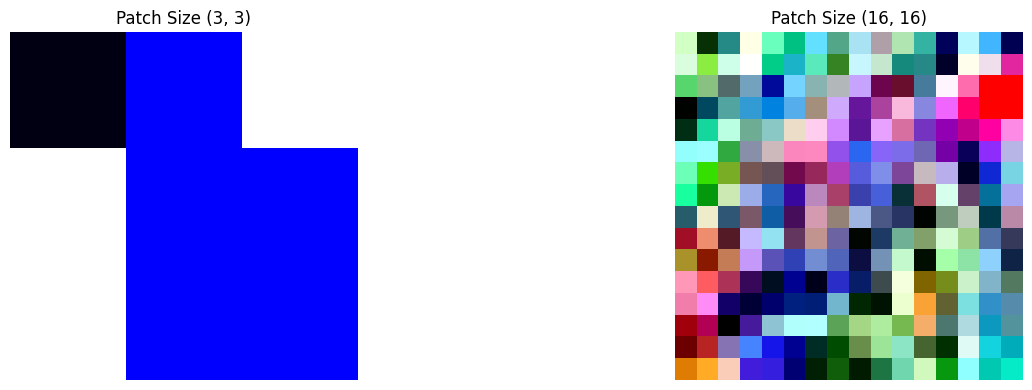

In [21]:
patch_generator.visualize_patches(trained_patches)

In [22]:
success_rates = patch_generator.evaluate_patches(trained_patches, testloader, target_class)
print("\nOverall Attack Success Rates:")
for size, rate in success_rates.items():
    print(f"Patch Size {size}: {rate:.2f}%")


Evaluating patch for size (3, 3)
Attack Success Rate (random placement): 12.82%
Attack Success Rate (center placement): 8.59%
Attack Success Rate (multiple placement): 13.07%

Evaluating patch for size (16, 16)
Attack Success Rate (random placement): 3.69%
Attack Success Rate (center placement): 1.42%
Attack Success Rate (multiple placement): 7.35%

Overall Attack Success Rates:
Patch Size (3, 3): 11.49%
Patch Size (16, 16): 4.15%


In [ ]:
def visualize_misclassified_patched_images(model, patch, dataloader, classes, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            # Display only if the original prediction is correct and the patched prediction is incorrect
            if original_preds[i] == labels[i] and patched_preds[i] != labels[i]:
                # Normalize back to [0, 1] range for visualization
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                # Plot images with a fixed size to match CIFAR-10
                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")
                axes[0].axis('off')

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")
                axes[1].axis('off')

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return

<ipython-input-41-910d709ec583>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load('adversarial_patch_cat_1.pth')


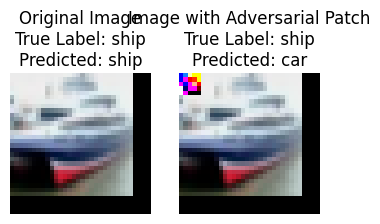

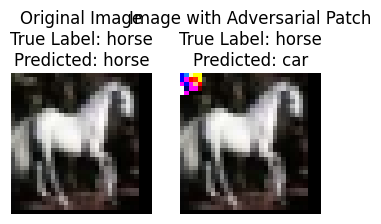

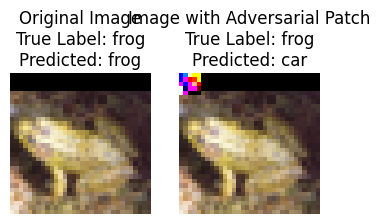

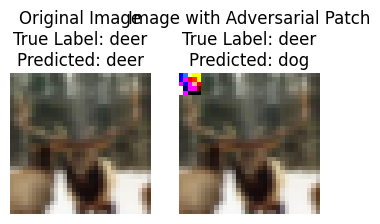

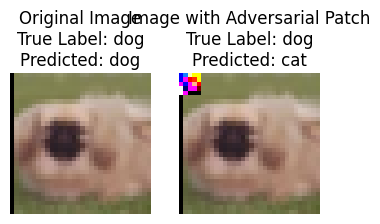

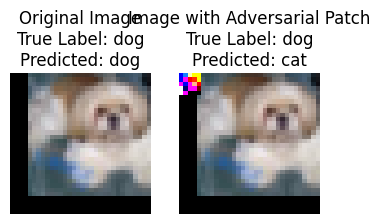

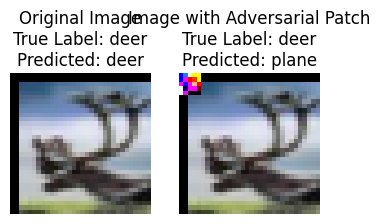

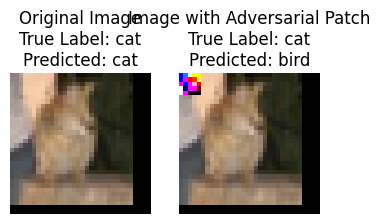

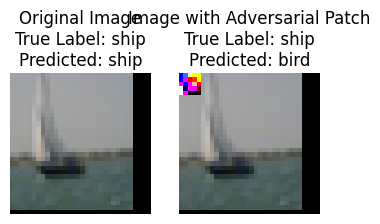

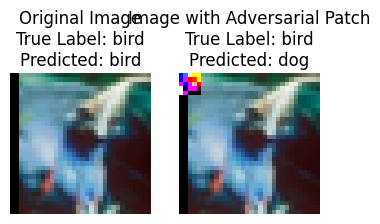

In [ ]:
# Load saved patch
patch = torch.load('adversarial_patch_cat_1.pth')
patch.requires_grad = True

# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize misclassified examples with the adversarial patch
visualize_misclassified_patched_images(model, patch, testloader, classes, num_examples=10)